# Introduction

This notebook reproduces the graphs for the introduction into transactions
under the EUTL provided at EUETS.INFO.

# Packages and options

In [1]:
import os
from pyeutl import download_data
from pyeutl.ziploader import (
    get_installations, get_accounts, get_transactions,
    get_compliance) 
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

## Get Data

Download the data from euets.info. This has to be done only once:

In [2]:
fn_zip = "./eutl.zip"
if not os.path.exists(fn_zip):
    download_data(fn_out=fn_zip)

In [3]:
def load_data(fn_zip, freq=None):
    """Load installation account and transaction data from zip file
    :param fn_zip: <string> name of zip file with eutl data
    :param freq: <string> frequency for resampling of transaction data"""
    # get installations
    df_inst = get_installations(fn_zip)
    # get accounts with selected installation information
    df_acc = get_accounts(fn_zip, 
                          df_installation=df_inst[["id", "name", "activity_id", "activity", "activityCategory", 
                                                   "nace_id", "nace", "naceCategory"]]) 
    # get compliance data with installation information
    df_comp = get_compliance(fn_zip, df_installation=df_inst)    
    # get transactions merged with account information
    cols = ['id', 'name', 'registry_id', 'accountHolder_id', 'accountType_id',
            'isRegisteredEutl', 'installation_id', 'registry', 'accountType', 
            'accountCategory', 'installationName', 'activity_id', 'activity', 
            'nace_id', 'nace', "naceCategory" ]
    df_trans = get_transactions(fn_zip, drop=["project_id"], freq=freq, 
                          df_account=df_acc[cols])
    return df_inst, df_acc, df_comp, df_trans

df_inst, df_acc, df_comp, df_trans = load_data(fn_zip, freq=None)

In [4]:
to_drop = ["tradingSystem_id"]
to_drop.extend(
    [f"{t}{v}" 
    for v in [
        "Account_id", 
        "IsRegisteredEutl", "AccountHolder_id", 
        "Installation_id", "InstallationName", "Activity_id", "Activity", 
        "Nace_id","Nace", "NaceCategory"]
    for t in ["transferring", "acquiring"]
    ]
)
df_t = (
    df_trans
    .query("tradingSystem_id == 'euets'")
    .dropna(axis=1, how='all')
    .drop(columns=to_drop)
    .assign(
        year=lambda x: x["date"].dt.year,
    )
)
df_t.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2015616 entries, 0 to 2016689
Data columns (total 23 columns):
 #   Column                           Dtype         
---  ------                           -----         
 0   id                               int64         
 1   transactionID                    object        
 2   date                             datetime64[ns]
 3   transactionTypeMain_id           int64         
 4   transactionTypeSupplementary_id  int64         
 5   unitType_id                      object        
 6   amount                           int64         
 7   transactionTypeMain              object        
 8   transactionTypeSupplementary     object        
 9   unitType                         object        
 10  transferringName                 object        
 11  transferringRegistry_id          object        
 12  transferringAccountType_id       object        
 13  transferringRegistry             object        
 14  transferringAccountType          object

## Unit Types

In [5]:
df_units = (
    df_t
    .pivot_table("amount", "year", "unitType", aggfunc="sum")
    .div(1_000_000)
    .round(0)
    #.stack()
    #.to_frame("amount")
    #.reset_index()
)
df_units

unitType,AAU - Assigned Amount Unit - Allowance issued for the 2008-2012 period and subsequent 5-year periods and is converted from an AAU,Allowance issued for the 2005-2007 period and not converted from an AAU or other Kyoto unit,CER - Certified Emission Reduction Unit,ERU - Emission Reduction Unit (Converted from an AAU),ERU - Emission Reduction Unit (Converted from an RMU),EU Aviation Allowances (EUAA),EU General Allowances (EUA),RMU - Removal Unit,Swiss Aviation Allowances (CHUA),Swiss General Allowances (CHU),tCER - Temporary CER
year,,,,,,,,,,,
2005,NaN,8006.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006,NaN,11410.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007,NaN,9435.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008,48019.0,5803.0,621.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009,18883.0,NaN,1013.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010,14856.0,NaN,1222.0,119.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011,13628.0,NaN,2028.0,433.0,NaN,NaN,300.0,38.0,NaN,NaN,NaN
2012,11219.0,NaN,2321.0,1978.0,NaN,226.0,4212.0,44.0,NaN,NaN,2.0
2013,3214.0,NaN,1807.0,1776.0,0.0,351.0,14873.0,18.0,NaN,NaN,6.0


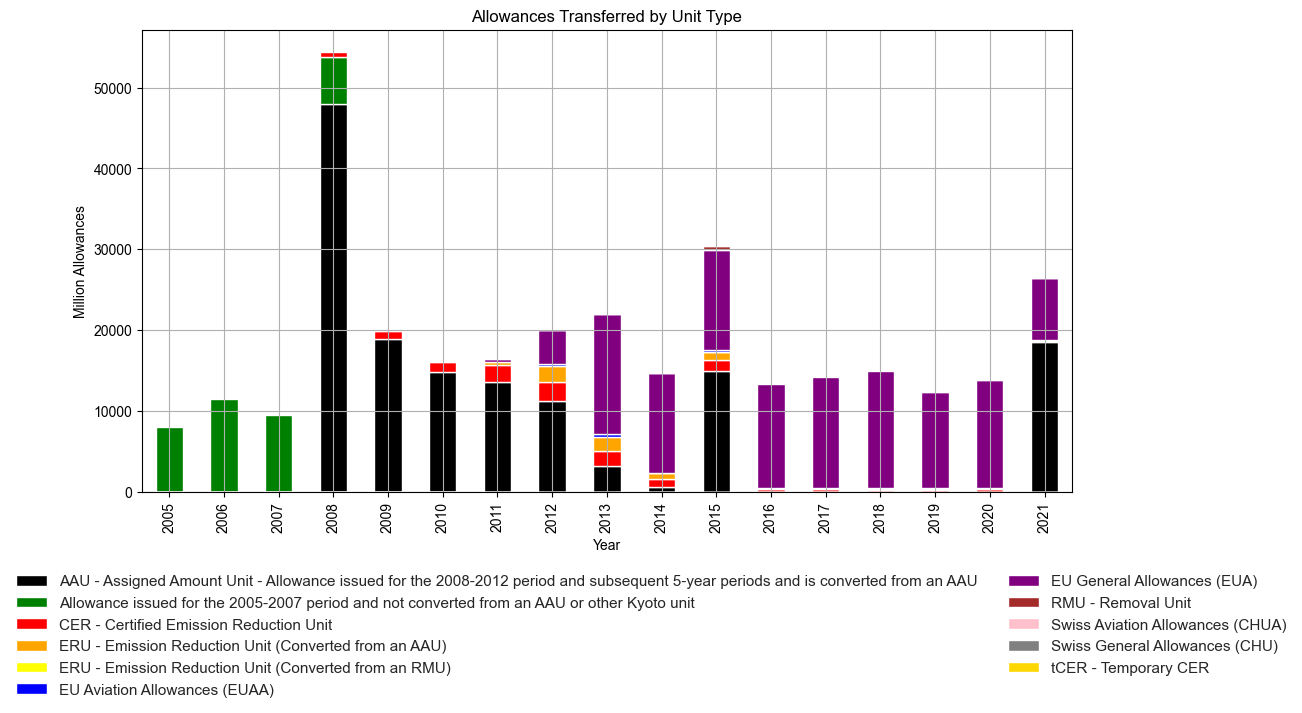

In [6]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.set_theme(style="darkgrid")  
colors = [
    "black", "green", "red", "orange", "yellow", "blue", 
    "purple", "brown", "pink", "grey", "gold"
]
sns.set_theme(style="darkgrid")  
df_units.plot(kind="bar", stacked=True, ax=ax, color=colors)
ax.legend(loc="upper left", bbox_to_anchor=(-0.15,-0.15), frameon=False, ncol=2)
ax.set_ylabel("Million Allowances")
ax.set_xlabel("Year")
ax.set_title("Allowances Transferred by Unit Type")
plt.savefig("./figures/allowances_transferred_by_unit.png", dpi=300, bbox_inches="tight")

## Transaction types

In [7]:
df_maint = (
    df_t
    .assign(
        MainTransactionType=lambda x: x["transactionTypeMain_id"].astype("string") + ": " + x["transactionTypeMain"]
    )
    .pivot_table("amount", "year", "MainTransactionType", aggfunc="sum")
    .div(1_000_000)
    .round(0)
    # .stack()
    # .to_frame("amount")
    # .reset_index()
)
df_maint

MainTransactionType,10: Internal - Internal transfer of unit/supplementary program transaction,1: Issuance - Initial creation of a unit,2: Conversion - Transformation of unit to create an ERU,3: External - External transfer of unit between registries,4: Cancellation - Internal transfer of unit,5: Retirement - Internal transfer of unit,6: Replacement - Internal transfer of unit,7: Carry-over - Change of validity to subsequent CP,8: Expiry Date Change
year,,,,,,,,,
2005,3701.0,4185.0,NaN,121.0,NaN,NaN,NaN,NaN,NaN
2006,7279.0,1986.0,NaN,428.0,1717.0,NaN,NaN,NaN,NaN
2007,6911.0,292.0,NaN,403.0,1830.0,NaN,NaN,NaN,NaN
2008,22641.0,27802.0,NaN,1591.0,2409.0,NaN,NaN,NaN,NaN
2009,14865.0,11.0,2.0,3986.0,1.0,1041.0,NaN,NaN,NaN
2010,10945.0,27.0,15.0,2915.0,16.0,2278.0,NaN,NaN,NaN
2011,10594.0,348.0,20.0,2670.0,14.0,2781.0,NaN,NaN,NaN
2012,14596.0,199.0,33.0,2809.0,43.0,2320.0,NaN,NaN,NaN
2013,18029.0,NaN,13.0,3558.0,23.0,421.0,NaN,NaN,2.0


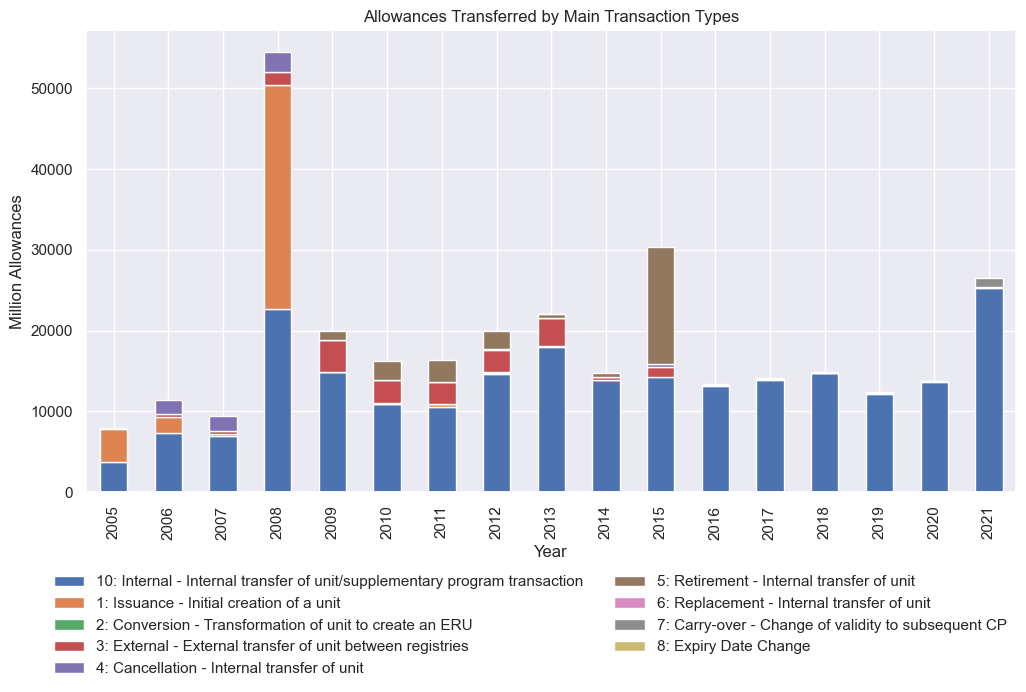

In [8]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.set_theme(style="darkgrid")  
df_maint.plot(kind="bar", stacked=True, ax=ax)
ax.legend(loc="upper left", bbox_to_anchor=(-0.05,-0.15), frameon=False, ncol=2)
ax.set_ylabel("Million Allowances")
ax.set_xlabel("Year")
ax.set_title("Allowances Transferred by Main Transaction Types")
plt.savefig("./figures/allowances_transferred_by_maintransaction.png", dpi=300, bbox_inches="tight")

In [9]:
map_supp = {
    "3: Retirement (2005-2007)": "other",
    "34: General allowances - Banking": "other",
    "39: Carry Over of AAUs": "other",
    "21: External transfer (2005-2007)": "other",
    "90: Deletion of allowances": "other",
    "71: Exchange": "other",
    "72: Exchanged": "other",
    "35: Allocation of aviation allowances": "other",
    "38: Carry Over of CERs or ERUs converted from AAUs": "other",
    "31: Issuance of general allowances": "other",
    "41: Cancellation and replacement": "other",
    "22: External transfer between art63a registries": "other",
    "30: Issuance of aviation allowances": "other",
    "86: Reverse of Excess Allocation": "other",
    "92: Reversal of Allowance Surrender": "other",
    "190: Reversal of deletion": "other",
    "4: Surrender Kyoto Units from AOHA": "other",
    "82: Reversal of surrender": "other",
    "104: Reversal of cancellation": "other",
    "75: AAU set aside": "other",
    "33: Aviation allowances - Banking": "other",
    "55: Correction to allowances": "other",
    "24: Issuance - Internal transfer Art 63a": "other",
    "76: International Transfer": "other",
    "26: Conversion of art63a allowances": "other",
    "171: Reversal of Exchange": "other",
    "136: Allocation of general allowances": "other",
    "93: Correction": "other",
    "63: International Allocation": "other",
    "135: Allocation of aviation allowances": "other",
    "172: Reversal of Transfer of Exchanged": "other",
    "91: Cancellation against deletion": "other",
    "48: Mandatory Cancellation": "other",
    }
df_suppt = (
    df_t
    .assign(
        SuppTransactionType=lambda x: 
            x["transactionTypeSupplementary_id"].astype("string") + ": " + x["transactionTypeSupplementary"]
    )
    .assign(
        SuppTransactionType=lambda x: x["SuppTransactionType"].replace(map_supp)
    )
    .pivot_table("amount", "year", "SuppTransactionType", aggfunc="sum")
    .div(1_000_000)
    .round(0)
)
df_suppt.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17 entries, 2005 to 2021
Data columns (total 10 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   0: No Supplementary Type                 17 non-null     float64
 1   1: Allowance cancellation (2005-2007)    8 non-null      float64
 2   2: Allowance surrender                   17 non-null     float64
 3   36: Allocation of general allowances     10 non-null     float64
 4   37: Auction delivery                     10 non-null     float64
 5   51: Allowance issue (2005-2007)          4 non-null      float64
 6   52: Allowance issue (2008-2012 onwards)  5 non-null      float64
 7   53: Allowance allocation                 8 non-null      float64
 8   61: Surrendered Allowance Conversion     4 non-null      float64
 9   other                                    17 non-null     float64
dtypes: float64(10)
memory usage: 1.4 KB


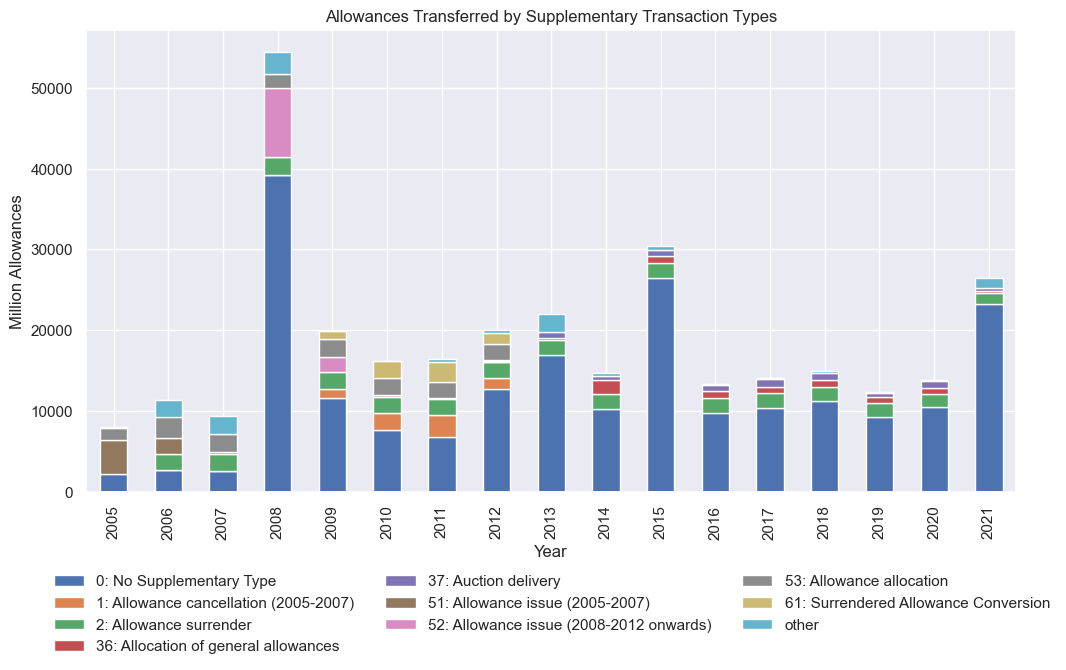

In [10]:
fig, ax = plt.subplots(figsize=(12, 6))
df_suppt.plot(kind="bar", stacked=True, ax=ax)
ax.legend(loc="upper left", bbox_to_anchor=(-0.05,-0.15), frameon=False, ncols=3)
ax.set_ylabel("Million Allowances")
ax.set_xlabel("Year")
ax.set_title("Allowances Transferred by Supplementary Transaction Types")
plt.savefig("./figures/allowances_transferred_by_supptransaction.png", dpi=300, bbox_inches="tight")

## Monthly transaction profile

(0.0, 18325.75)

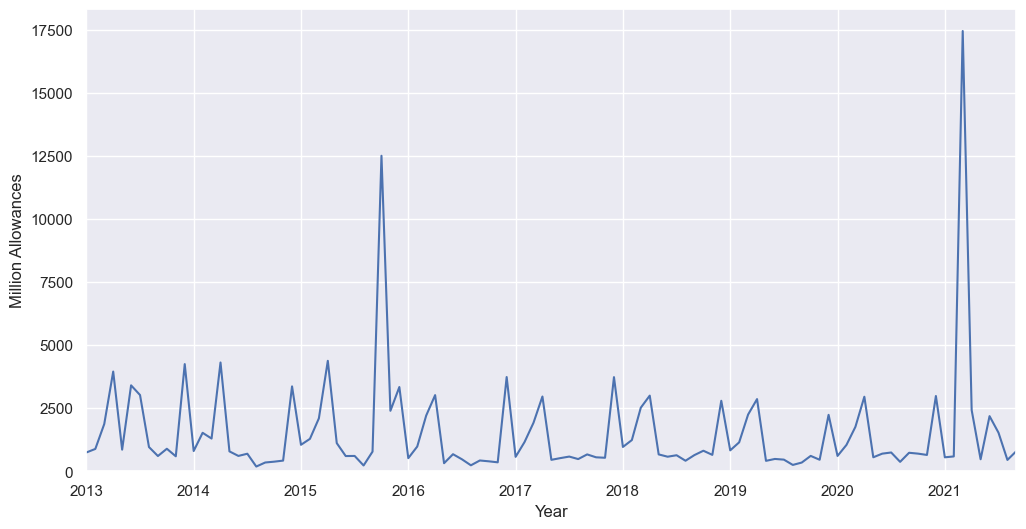

In [11]:
fig, ax = plt.subplots(figsize=(12, 6))
df_m = df_t.groupby(pd.Grouper(key="date", freq="ME"))["amount"].sum().div(1_000_000).round(0)["2013":]
df_m.plot(ax=ax)
ax.set_ylabel("Million Allowances")
ax.set_xlabel("Year")
ax.set_ylim(0)

## Auctions

In [12]:
df_a = df_t.query("transactionTypeSupplementary_id == 37")
df_a.acquiringName.unique()

array(['ECC AG Auction Delivery Account EU',
       'ECC AG Auction Delivery Account PL',
       'ECC AG Auction Delivery Account DE',
       'UK Auction Trust Account - DECC'], dtype=object)